Particle swarms
============

In Underworld a swarm is a set of particles which are free to advect anywhere inside the domain and do not have the topological constraints of a mesh. The particles may be advected using a velocity defined by the user.

Swarm particles are utilised to store data relevant to the user's modelling. In Underworld, particles often track advecting material information (such as viscosity or density). For example, this may be used to simulate a subducting slab.

In this notebook we will examine how to create, setup and use particle swarms. 

**This notebook is broken down into the following examples:**
1. Creating simple global swarms with different layouts.
2. Adding particles to a swarm based on a coordinate list.
3. Directly editing swarms.
4. Adding swarm particle variables.
5. Creating shapes using swarms.

**Keywords:** swarms, particles, shapes


In [1]:
import underworld as uw
import glucifer
import numpy as np

Setting up a global swarm
----------

Set up a random distribution of particles over a given mesh. The density of particles per cell controls the total number of particles.

**Create a mesh**

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

**Initialise a swarm**

Initialise a swarm on a given mesh object.

In [3]:
swarm = uw.swarm.Swarm( mesh=mesh )

**Create a layout object**

Layout objects are used to populate the swarm across the entire mesh domain.

The ``GlobalSpaceFillerLayout`` layout (default) fills the domain with particles in a quasi-random pattern. It utilises Sobol sequences to generate global particle locations which are more uniformly distributed than that achieved by a purely random generator.

In [4]:
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

**Now utilise the layout**

In [5]:
swarm.populate_using_layout( layout=swarmLayout )

**Plot resulting swarm from ``GlobalSpaceFillerLayout``**


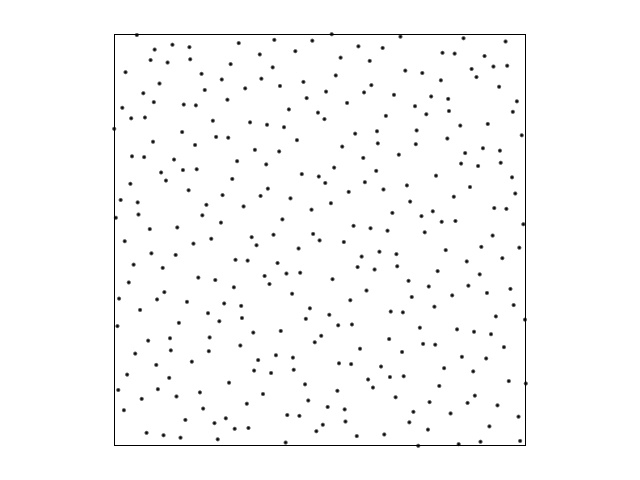

In [6]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig1.show()

**Layout types: Gauss points**

We demonstrate the ``PerCellGaussLayout`` type. This puts a particle on each of the Gauss points within each mesh element.


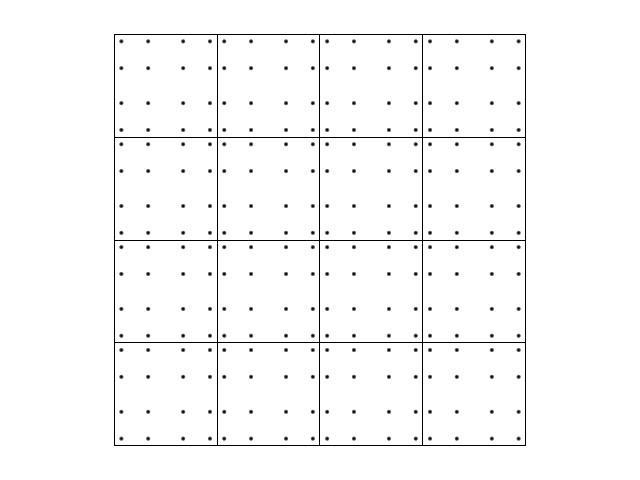

In [7]:
swarm = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=4 )
swarm.populate_using_layout( layout=swarmLayout )
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig2.append( glucifer.objects.Mesh(mesh) )
fig2.show()

**Layout types: random points per cell**

While the global layout uses a uniform quasi-random distribution of points, the ``PerCellRandomLayout`` layout uses a purely random distribution within each element. This will generally result in a less uniform particle distribution.


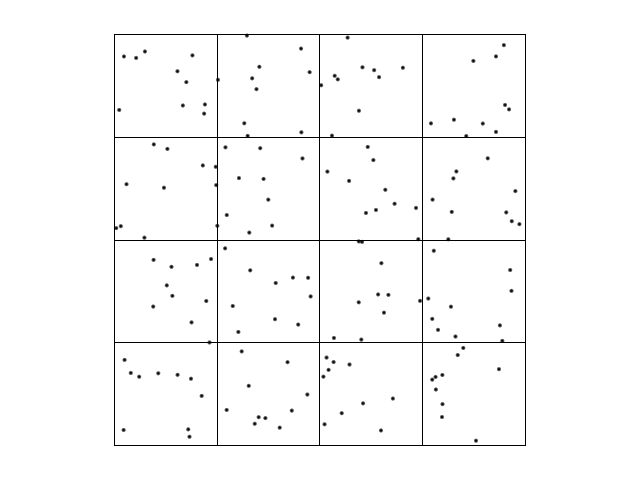

In [8]:
swarm = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell = 10)
swarm.populate_using_layout( layout=swarmLayout )
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig3.append( glucifer.objects.Mesh(mesh) )
fig3.show()

**Layout types: quasi-random points per cell**

The ``PerCellSpaceFillerLayout`` uses a uniform quasi-random distribution of points as the global layout does, but applied to each element.


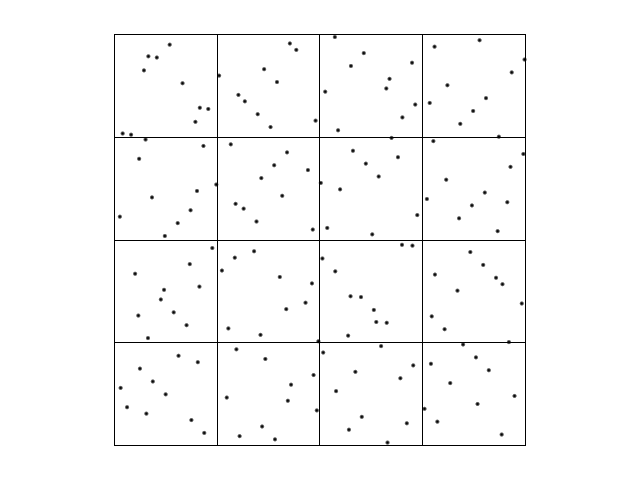

In [9]:
swarm = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell = 10)
swarm.populate_using_layout( layout=swarmLayout )
fig4 = glucifer.Figure()
fig4.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig4.append( glucifer.objects.Mesh(mesh) )
fig4.show()

Creating a swarm from a coordinate list
---------

We can use the swarm particle method, with the above plotting method, to visualise the mesh nodes. 
As an example, let us create two swarms and arbitrarily set the particle coordinates to coincide with the nodes on the mesh and sub mesh.

First, lets look at what the data for the first 5 points looks like for the mesh.

In [10]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))
print(mesh.data[0:5])

[[ 0.    0.  ]
 [ 0.25  0.  ]
 [ 0.5   0.  ]
 [ 0.75  0.  ]
 [ 1.    0.  ]]


Since these 5 entries are the x, y (in 2D) coordinates for each mesh point, then they can be used directly to set the positions for the swarm particles

In [11]:
# setup a new swarm. At this point there is no data in the swarm
swarmMesh = uw.swarm.Swarm( mesh=mesh )
# setup an array containing the position data from the mesh data
swarmCoords = mesh.data
# use this array to add particles to the newly created swarm
swarmMesh.add_particles_with_coordinates( swarmCoords )

# setup a new swarm
swarmSubMesh = uw.swarm.Swarm( mesh=mesh ) # note this must be the whole mesh
# setup an array containing the position data from the sub mesh data
swarmCoords = mesh.subMesh.data
# use this array to add particles to the newly created swarm
swarmSubMesh.add_particles_with_coordinates( swarmCoords )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

The final output from this will be a linear array with the same number of entries as there are nodes in the dQ0 sub mesh (shown above).

**Plot meshes**

Now we can plot these two swarms to see the Q1 linear mesh (4 nodes per element) and the dQ0 sub mesh (single node inside each element).


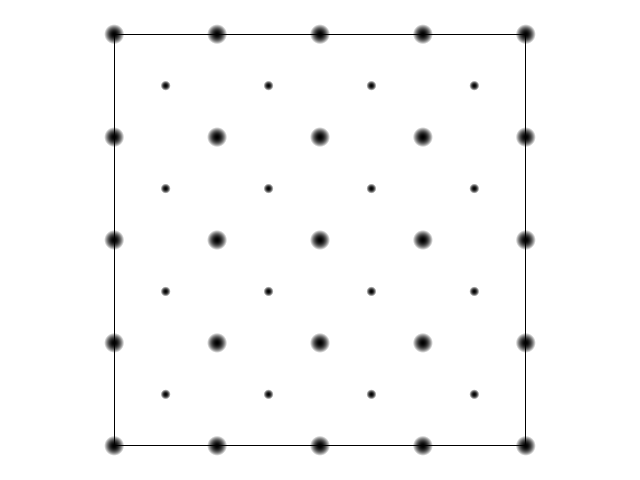

In [12]:
fig5 = glucifer.Figure()
fig5.append( glucifer.objects.Points(swarm=swarmMesh,    pointSize=20, colourBar = False) )
fig5.append( glucifer.objects.Points(swarm=swarmSubMesh, pointSize=10, colourBar = False) )
fig5.show()

Modifying particle positions
-----

Here we will demonstrate how to edit the coordinates for a single swarm particle.

**Create a new swarm using particle coordinates**

In [13]:
# initialise a swarm
swarmCustom = uw.swarm.Swarm( mesh=mesh )
swarmCoords = np.array([ [0.2,0.2], [0.4,0.4],[0.6,0.6],[0.8,0.8],[1.8,1.8]])
# use this array to add particles to the newly created swarm
# note that the array returned from the following method specifies the 
# local identifier for the added particles.  particles which are not 
# inside the local domain (they may live on other processors), will 
# be signified with a -1
swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3, -1], dtype=int32)

**Plot current positions for swarm particles**



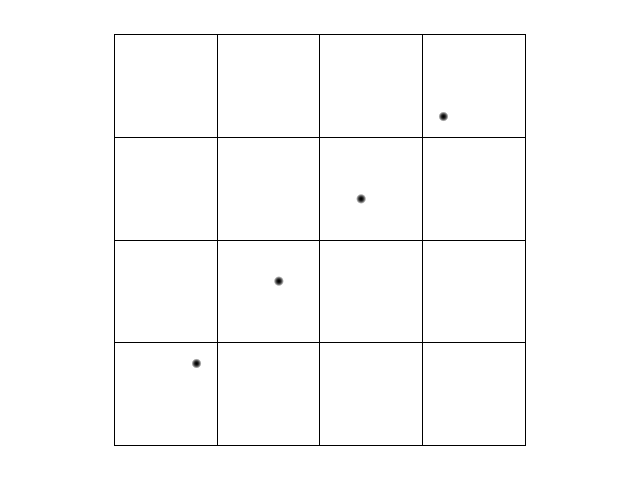

In [14]:
fig6 = glucifer.Figure()
fig6.append( glucifer.objects.Points(swarm=swarmCustom, pointSize=10, colourBar=False) )
fig6.append( glucifer.objects.Mesh(mesh))
fig6.show()

**Shift a single particle**

Let's move a single particle. We will simply move the particle with local index 1, which as you can determinen from the array returned from `add_particles_with_coordinates` is the particle with coordinates `(0.4,0.4)`.

Note that we need to use the `deform_swarm` context manager to modify particle locations. 

In [15]:
with swarmCustom.deform_swarm():
    swarmCustom.particleCoordinates.data[1] = (0.4,0.5)

**Replot with shifted particle**


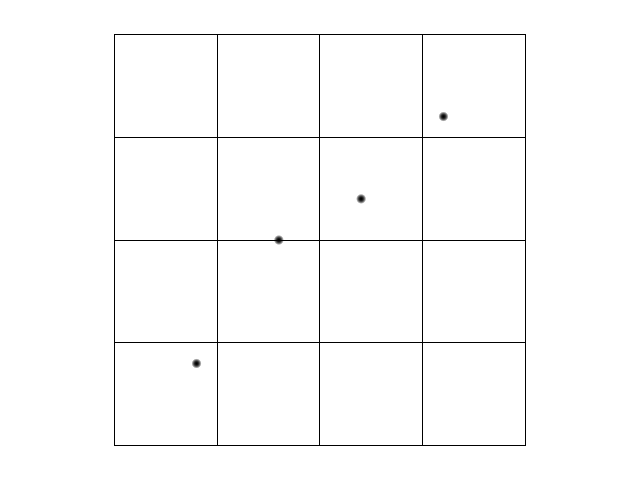

In [16]:
fig6.show()

Adding particle variables
---------

In this example we will add a new variable for the particles and choose it's value based on the temperature at the particle's spatial coordinates. 

**Create new variable for swarm object**

Firstly, create a new variable (a 'float' in this case) attached to the swarm object made in the previous example.

In [17]:
swarmVariable = swarmCustom.add_variable( dataType="float", count=1 )

Let's set some data on the variable

In [18]:
swarmVariable.data[0] = 1.
swarmVariable.data[1] = 10.
swarmVariable.data[2] = 100.
swarmVariable.data[3] = 1000.

**Plot swarm particles using new variable as the colour**


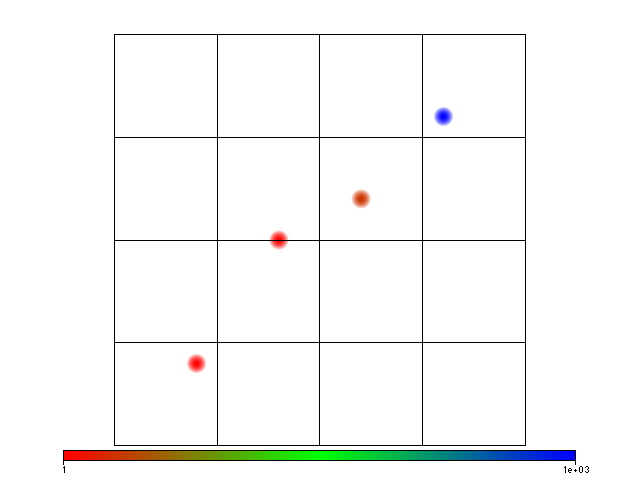

In [19]:
fig7 = glucifer.Figure()
fig7.append( glucifer.objects.Points( swarm=swarmCustom, pointSize=20, fn_colour=swarmVariable, colourBar = True,
                                colours="red green blue") )
fig7.append( glucifer.objects.Mesh(mesh))
fig7.show()

Making shapes
-----

This example will demonstrate the creation of shapes using your swarm variables. These shapes often form proxys for the materials in your models. 

For more information on how this method can be used to set material parameters to particles see the **StokesSinker** example.

**Create a new high resolution mesh**

In [20]:
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (64, 64), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )

**Create a swarm with quasi-random positions on the mesh**

In [21]:
# initialise a swarm. Note this must be the whole mesh.
swarm = uw.swarm.Swarm( mesh=mesh )
# add a data variable which will store an index to determine material
materialIndex = swarm.add_variable( dataType="int", count=1 )
# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# utilise the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Plot the swarm**


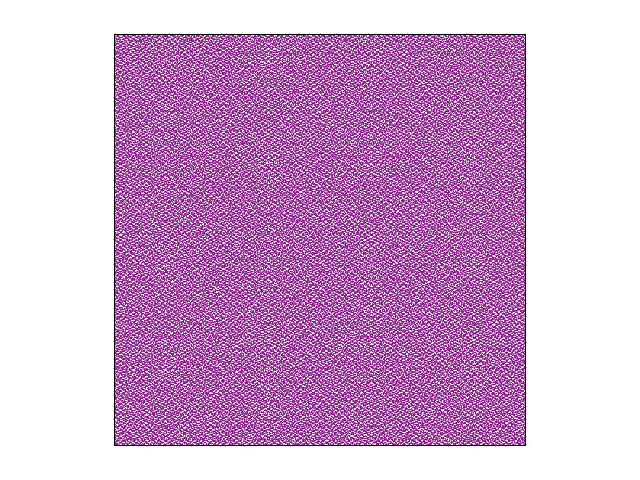

In [22]:
fig8 = glucifer.Figure()
fig8.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialIndex, colours='blue red', 
                               colourBar = False, pointSize=2.0 ) )
fig8.show()

**Define a shape: circle**

We want our `materialIndex` to define a circle. 

Here we use loops to traverse the particles and define an index depending on the particle's coordinates. More efficient ways to achieve this are presented in the **Functions** section of the user guide.

Firstly, specify parameters for the circle

In [23]:
circleRadius = 0.1
circleCentre = (0.5, 0.5)

Use the location of each particle to set the index depending on whether the position is inside the circle or not.

In [24]:
for index, coord in enumerate(swarm.particleCoordinates.data):
    x = coord[0]
    z = coord[1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialIndex.data[index] = 1
    else:
        materialIndex.data[index] = 0


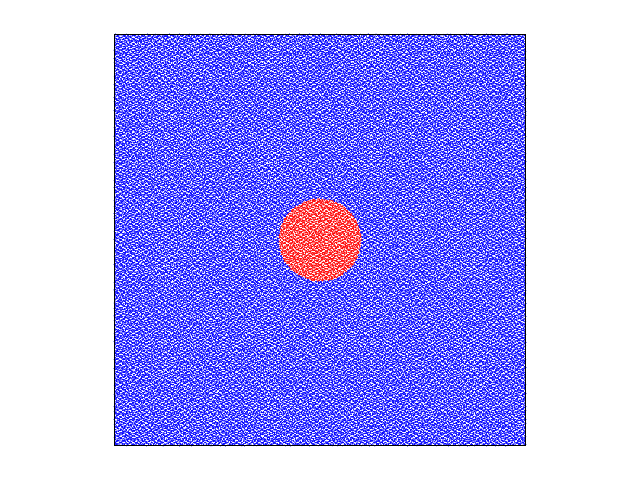

In [25]:
fig8.show()